# Modelo Regresión Logística: Encuesta Reddit Chile

## Conexión a fuente de datos

In [39]:
import numpy as np
import pandas as pd

In [40]:
df = pd.read_pickle("data/df_encuesta.pkl")

In [41]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170 entries, 0 to 1181
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   edad                       1170 non-null   int32
 1   religion                   1170 non-null   int8 
 2   sexo_Hombre                1170 non-null   uint8
 3   sexo_Mujer                 1170 non-null   uint8
 4   orientacion_Bisexual       1170 non-null   uint8
 5   orientacion_Heterosexual   1170 non-null   uint8
 6   orientacion_Homosexual     1170 non-null   uint8
 7   ocupacion_Estudio          1170 non-null   uint8
 8   ocupacion_Ninguna          1170 non-null   uint8
 9   ocupacion_Trabajo          1170 non-null   uint8
 10  ocupacion_Trabajo;Estudio  1170 non-null   uint8
 11  region_I                   1170 non-null   uint8
 12  region_II                  1170 non-null   uint8
 13  region_III                 1170 non-null   uint8
 14  region_IV               

In [42]:
df.head()

,edad,religion,sexo_Hombre,sexo_Mujer,orientacion_Bisexual,orientacion_Heterosexual,orientacion_Homosexual,ocupacion_Estudio,ocupacion_Ninguna,ocupacion_Trabajo,...,deporte_4horas,perro_agua,perro_atom_humber,perro_bus,perro_chilaquil,perro_ladron,perro_lipigas,perro_matapacos,perro_washington,perro_waton
0,27,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,30,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
2,26,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,18,1,1,0,0,1,0,1,0,0,...,1,0,0,0,0,1,0,0,0,0
4,19,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1


# Selección de variables predictoras y de respuesta.

In [43]:
X = df.loc[:, ~df.columns.isin(['politica_izquierda'])]
y = df['politica_izquierda']

# Generación data de entrenamiento y testeo más balanceo

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state = 42)

In [45]:
# datos de entrenamiento antes de balance 
y_train.value_counts()

1    517
0    419
Name: politica_izquierda, dtype: int64

In [46]:
# balaceo con sobremuestro
y_train_Q = y_train[y_train == 1]
y_train_NQ = y_train[y_train == 0]
y_train_NQ = y_train_NQ.sample(len(y_train_Q), replace = True, 
                               random_state = 42)
y_train = pd.concat([y_train_Q, y_train_NQ], axis=0)
X_train = X_train.loc[y_train.index,:]

del [y_train_Q, y_train_NQ]

In [47]:
# datos de entrenamiento despueés de balanceo
y_train.value_counts()

1    517
0    517
Name: politica_izquierda, dtype: int64

# Grid-Search

In [48]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

12

# CV AdaBoost

In [49]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression

modelo_base = LogisticRegression(max_iter = 10000, 
                                 random_state = 42)
arboles_ada = AdaBoostClassifier(base_estimator = modelo_base,
                                 n_estimators = 10, 
                                 random_state = 42)
cv_ada = cross_validate(arboles_ada,
                        X = X_train,
                        y = y_train,
                        cv = 5, 
                       verbose = 1) 
cv_ada

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished


{'fit_time': array([0.05773211, 0.06733775, 0.06199765, 0.06337976, 0.08330631]),
 'score_time': array([0.00398946, 0.00398898, 0.0039885 , 0.00299168, 0.00498605]),
 'test_score': array([0.61835749, 0.64251208, 0.61835749, 0.62801932, 0.65048544])}

In [50]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV

grilla = {'n_estimators':[100, 200, 500, 1000], 
          'learning_rate':[0.01, 0.05, 0.1]}

gs_ada = GridSearchCV(arboles_ada,
                       param_grid = grilla, 
                       cv = 5,
                       verbose = 1,
                       n_jobs = cores)

modelo_ada = gs_ada.fit(X_test, y_test)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [51]:
modelo_ada.best_params_

{'learning_rate': 0.01, 'n_estimators': 500}

In [52]:
modelo_ada_gr = modelo_ada.best_estimator_

# Resultados modelo

## Métricas

In [53]:
y_pred_train = modelo_ada_gr.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, columns=["Y_predicha"], 
                            index = y_train.index)

from sklearn.metrics import classification_report
print("Resultado en data de entrenamiento:")

print(classification_report(y_train, y_pred_train))

Resultado en data de entrenamiento:
              precision    recall  f1-score   support

           0       0.60      0.56      0.57       517
           1       0.58      0.62      0.60       517

    accuracy                           0.59      1034
   macro avg       0.59      0.59      0.59      1034
weighted avg       0.59      0.59      0.59      1034



In [54]:
y_pred_test = modelo_ada_gr.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, columns=["Y_predicha"], 
                           index = y_test.index)

print("Resultado en data de prueba:")

print(classification_report(y_test, y_pred_test))

Resultado en data de prueba:
              precision    recall  f1-score   support

           0       0.66      0.63      0.65       117
           1       0.65      0.68      0.66       117

    accuracy                           0.65       234
   macro avg       0.65      0.65      0.65       234
weighted avg       0.65      0.65      0.65       234



**Precision**: Cada vez que el modelo determina que un usuario de Reddit es de izquierda, acertará un 65% de las veces.  
**Recall**: El modelo es capaz de identificar el 68% de las personas que son efectivamente de izquierda.  
**Accuracy**: El modelo acierta un 65% de las veces.

## Curva ROC & AUC

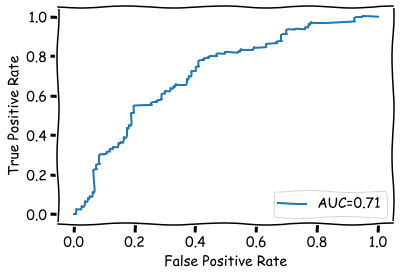

In [55]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_prob_test = modelo_ada_gr.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_test)
auc = round(metrics.roc_auc_score(y_test, y_prob_test),2)

with plt.xkcd():
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()